# Colocate data from NorESM and CESM2 and calculate aerosol biases

In [1]:
import pyaerocom as pya
#import xarray as xr
from warnings import filterwarnings
from imports import (
        np, xr, mpl, plt, os,
        sys, crt
    )
ccrs = crt.crs

base_dir = '/home/notebook/basics/saved_data/'

filterwarnings('ignore')
pya.__version__

/opt/conda/lib/python3.7/site-packages/geonum/__init__.py:39: UserWarning: Plotting of maps etc. is deactivated, please install Basemap
  warn('Plotting of maps etc. is deactivated, please install Basemap')


'0.8.1.dev4'

In [2]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
#cesm_path = '/home/notebook/basics/saved_data/aerosolratio_cesm2_2006.nc'
#noresm_path = '/home/notebook/basics/saved_data/aerosolratio_noresm_2006.nc'
cesm_path = '/home/notebook/basics/saved_data/aerosol_props_cesm2_2000_2010.nc'
noresm_path = '/home/notebook/basics/saved_data/aerosol_props_noresm_2000_2010.nc'
#basics/saved_data/aerosol_props_noresm_2000_2010.nc
os.path.exists(cesm_path)

True

Assign metadata id values

Read into pyaerocom and regrid to the lower-resolution NorESM

In [4]:
cesm_ds = xr.open_dataset(cesm_path)
cesm_ds.data_vars

Data variables:
    mmroa       (month, lat, lon) float32 ...
    mmrso4      (month, lat, lon) float32 ...
    mmrbc       (month, lat, lon) float32 ...
    aero_ratio  (month, lat, lon) float32 ...

In [5]:
noresm_ds = xr.open_dataset(noresm_path)
noresm_ds.data_vars

Data variables:
    mmroa       (month, lat, lon) float32 ...
    mmrso4      (month, lat, lon) float32 ...
    mmrbc       (month, lat, lon) float32 ...
    aero_ratio  (month, lat, lon) float32 ...

Read out the netcdf files and regrid to the NorESM grid

In [6]:
ds_comp = xr.Dataset()
for i in cesm_ds.data_vars: # assume the variables are the same between the models
    #print(i)
    _cesm = pya.GriddedData(cesm_path, var_name=i)
    _noresm = pya.GriddedData(noresm_path, var_name=i) # Couldn't I just do this once?
    
    _cesm.metadata['data_id']='CESM'
    _noresm.metadata['data_id']='NorESM'

    _cesm_regridded = _cesm.regrid(_noresm)
    _cesm_str = 'cesm_' + i; _noresm_str = 'noresm_' + i;
    #print(_cesm_str, _noresm_str)
    ds_comp[_noresm_str] = _noresm.to_xarray()
    ds_comp[_cesm_str] = _cesm_regridded.to_xarray()

In [7]:
ds_comp

<xarray.Dataset>
Dimensions:            (lat: 96, lon: 144, month: 12)
Coordinates:
  * month              (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
  * lat                (lat) float64 -90.0 -88.11 -86.21 ... 86.21 88.11 90.0
  * lon                (lon) float64 0.0 2.5 5.0 7.5 ... 350.0 352.5 355.0 357.5
    lev                float64 ...
Data variables:
    noresm_mmroa       (month, lat, lon) float32 dask.array<chunksize=(12, 96, 144), meta=np.ndarray>
    cesm_mmroa         (month, lat, lon) float32 ...
    noresm_mmrso4      (month, lat, lon) float32 dask.array<chunksize=(12, 96, 144), meta=np.ndarray>
    cesm_mmrso4        (month, lat, lon) float32 ...
    noresm_mmrbc       (month, lat, lon) float32 dask.array<chunksize=(12, 96, 144), meta=np.ndarray>
    cesm_mmrbc         (month, lat, lon) float32 ...
    noresm_aero_ratio  (month, lat, lon) float32 dask.array<chunksize=(12, 96, 144), meta=np.ndarray>
    cesm_aero_ratio    (month, lat, lon) float32 ...

In [8]:
cesm_ratio = pya.GriddedData(cesm_path, var_name='aero_ratio')
noresm_ratio = pya.GriddedData(noresm_path, var_name='aero_ratio')

In [9]:
cesm_ratio.metadata['data_id']='CESM'
noresm_ratio.metadata['data_id']='NorESM'

cesm_regridded = cesm_ratio.regrid(noresm_ratio)
cesm_regridded

pyaerocom.GriddedData
Grid data: <iris 'Cube' of aero_ratio / (1) (month: 12; latitude: 96; longitude: 144)>

In [10]:
ds = xr.Dataset()
ds['noresm_ratio'] = noresm_ratio.to_xarray()
ds['cesm_ratio'] = cesm_regridded.to_xarray()
ds['aerosol_ratio_bias'] = ds['noresm_ratio'] - ds['cesm_ratio']
#ds['fractional_ratio_bias'] = ds['aerosol_ratio_bias'] / ds['noresm_ratio']

Text(0.5,0,'Organic Aerosol mmr')

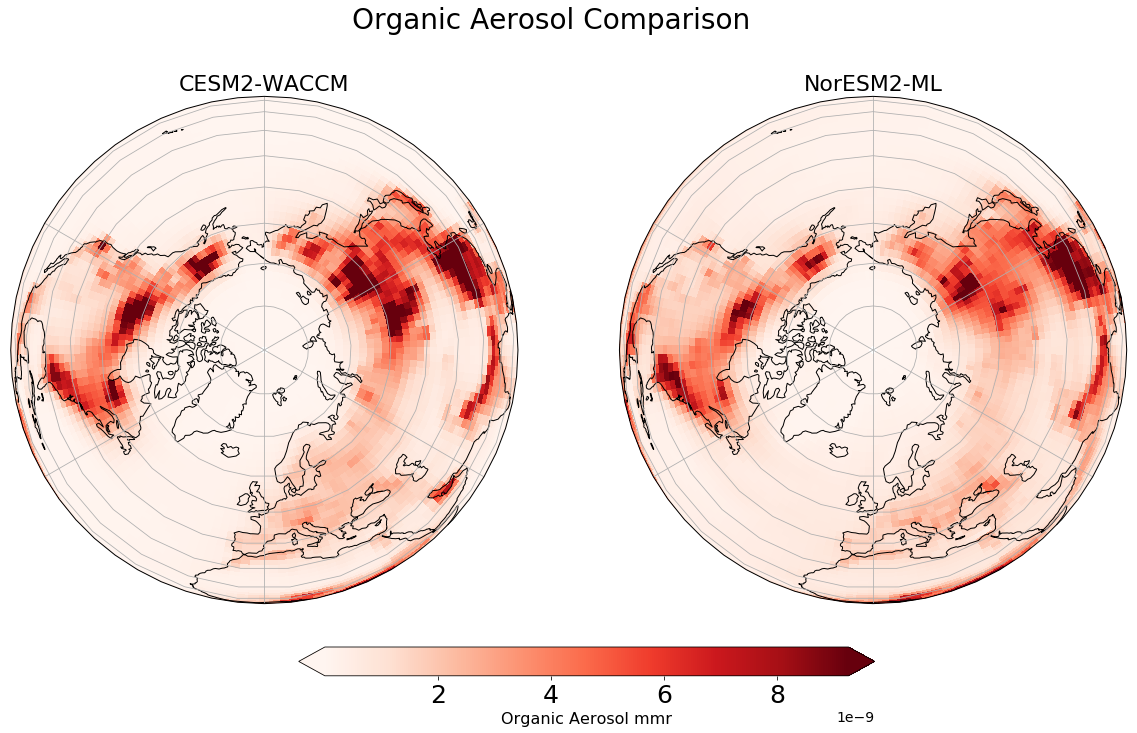

In [11]:
fig = plt.figure(1, figsize=[20,10])

# Plot 1 for Northern Hemisphere subplot argument (nrows, ncols, nplot)
# here 1 row, 2 columns and 1st plot
ax1 = plt.subplot(1, 2, 1, projection=ccrs.Orthographic(0, 90))

# Plot 2 for Southern Hemisphere
# 2nd plot 
ax2 = plt.subplot(1, 2, 2, projection=ccrs.Orthographic(0, 90))

minval = 0
maxval = 1

for ax,t,n in zip([ax1, ax2], ["cesm_mmroa", "noresm_mmroa"], ['CESM2-WACCM','NorESM2-ML']):
#    map = ds_comp[t][6].plot(ax=ax, vmin=minval, vmax=maxval, 
    map = ds_comp[t][6].plot(ax=ax,
                                           transform=ccrs.PlateCarree(), 
                                           cmap='Reds', 
                                           add_colorbar=False, robust=True)
    ax.set_title(n , fontsize=22)
    ax.coastlines()
    ax.gridlines()

    
# Title for both plots
fig.suptitle('Organic Aerosol Comparison', fontsize=28)


cb_ax = fig.add_axes([0.325, 0.05, 0.4, 0.04])

cbar = plt.colorbar(map, cax=cb_ax, extend='both', orientation='horizontal', fraction=0.046, pad=0.04)
cbar.ax.tick_params(labelsize=25)
cbar.ax.set_xlabel('Organic Aerosol mmr', fontsize=16)

In [12]:
filename = "aero_ratio_comparison_polar_2006"
fig.savefig(base_dir + filename  + '.pdf')
fig.clf()

In [13]:
filename = "aero_ratio_comparison_polar_2006.png"
fig.savefig(base_dir + filename,format = 'png', dpi = 400)
fig.clf()

<function matplotlib.pyplot.colorbar(mappable=None, cax=None, ax=None, **kw)>

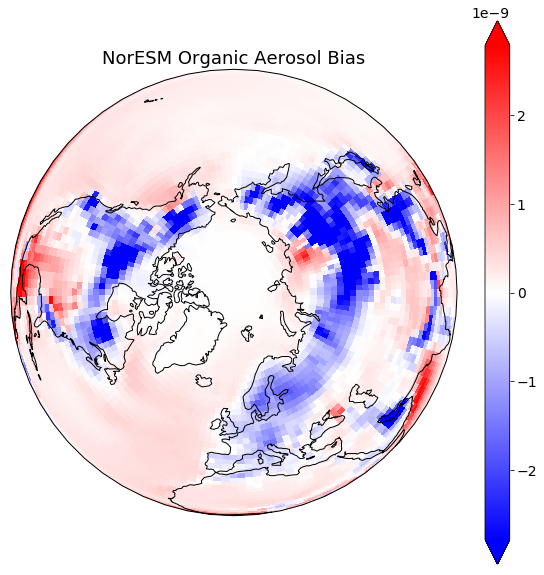

In [14]:
_oa_bias_july = (ds_comp['noresm_mmroa'] - ds_comp['cesm_mmroa'])[6]
fig2 = plt.figure(2, figsize=[10,10])

# We're using cartopy and are plotting in Orthographic projection 
# (see documentation on cartopy)
ax = plt.subplot(1, 1, 1, projection=ccrs.Orthographic(0, 90))
ax.coastlines()

# We need to project our data to the new Orthographic projection and for this we use `transform`.
# we set the original data projection in transform (here PlateCarree)
#noresm_ratio.plot(ax=ax2, transform=ccrs.PlateCarree(), cmap='coolwarm', robust=True)
#ds['aerosol_ratio_bias'].plot(ax=ax, transform=ccrs.PlateCarree(), cmap='coolwarm', robust=True)
_oa_bias_july.plot(ax=ax, transform=ccrs.PlateCarree(), cmap='bwr', robust=True)

# One way to customize your title
plt.title('NorESM Organic Aerosol Bias', fontsize=18)
plt.colorbar

Text(0.5,0,'Organic Aerosol Fraction')

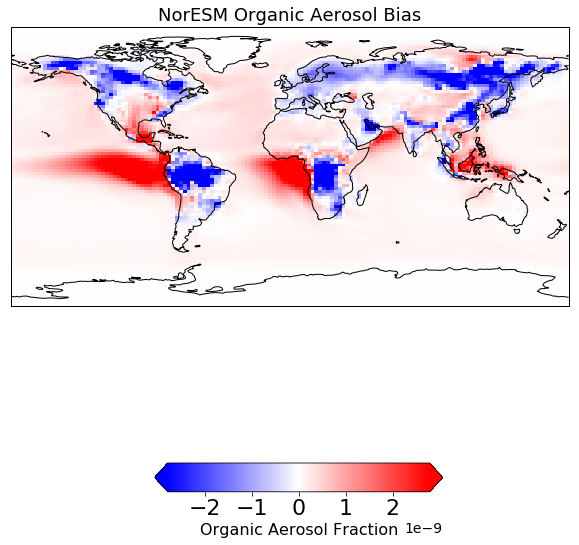

In [16]:
_oa_bias_july = (ds_comp['noresm_mmroa'] - ds_comp['cesm_mmroa'])[6]
fig2 = plt.figure(2, figsize=[10,10])

# We're using cartopy and are plotting in Orthographic projection 
# (see documentation on cartopy)
ax = plt.subplot(1, 1, 1, projection=ccrs.PlateCarree())
ax.coastlines()

# We need to project our data to the new Orthographic projection and for this we use `transform`.
# we set the original data projection in transform (here PlateCarree)
#noresm_ratio.plot(ax=ax2, transform=ccrs.PlateCarree(), cmap='coolwarm', robust=True)
#ds['aerosol_ratio_bias'].plot(ax=ax, transform=ccrs.PlateCarree(), cmap='coolwarm', robust=True)
map = _oa_bias_july.plot(ax=ax, transform=ccrs.PlateCarree(), cmap='bwr', robust=True, add_colorbar = False)

# One way to customize your title
#plt.colorbar
plt.title('NorESM Organic Aerosol Bias', fontsize=18)

cb_ax = fig2.add_axes([0.325, 0.05, 0.4, 0.04])

cbar = plt.colorbar(map, cax=cb_ax, extend='both', orientation='horizontal', fraction=0.046, pad=0.04)
cbar.ax.tick_params(labelsize=22)
cbar.ax.set_xlabel('Organic Aerosol Fraction', fontsize=16)

Text(0.5,0.98,'NorESM Organic Aerosol biases')

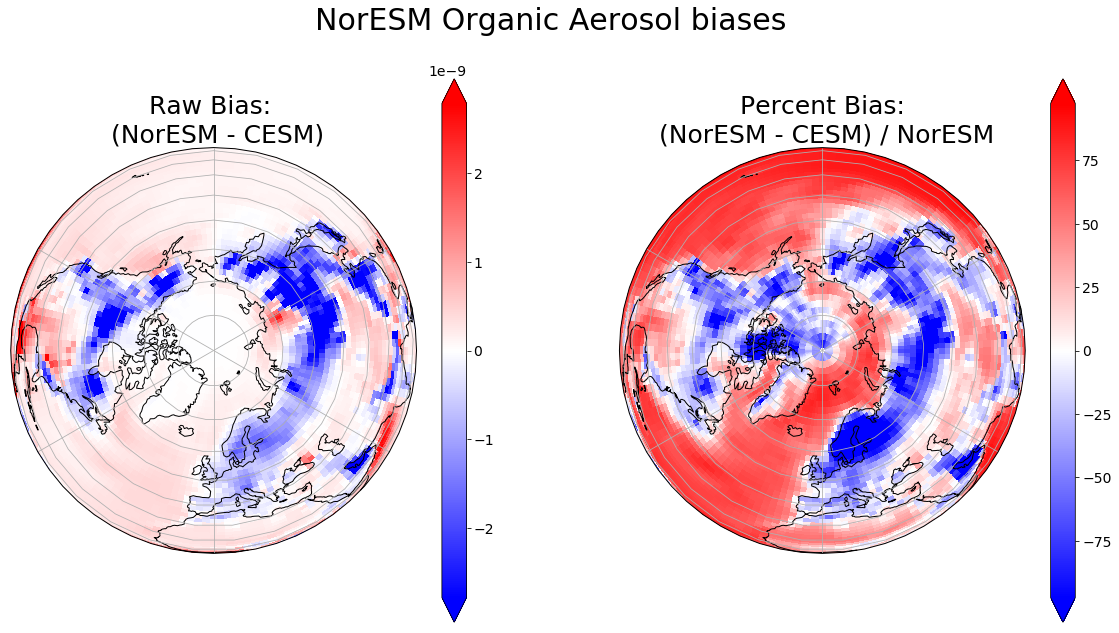

In [17]:
_oa_bias_july = (ds_comp['noresm_mmroa'] - ds_comp['cesm_mmroa'])[6]
_oa_fracbias_july = 100 * _oa_bias_july / (ds_comp['noresm_mmroa'][6])

fig2 = plt.figure(2, figsize=[20,10])

# Plot 1 for Northern Hemisphere subplot argument (nrows, ncols, nplot)
# here 1 row, 2 columns and 1st plot
ax1 = plt.subplot(1, 2, 1, projection=ccrs.Orthographic(0, 90))

# Plot 2 for Southern Hemisphere
# 2nd plot 
ax2 = plt.subplot(1, 2, 2, projection=ccrs.Orthographic(0, 90))

minval = -1
maxval = 1
titles = ['Raw Bias: \n (NorESM - CESM)','Percent Bias:\n (NorESM - CESM) / NorESM']
#titles = ['Raw Bias: \n (CESM - NorESM)','Fractional Bias:\n  (C$_{ESM}$ - NorESM)}{NorESM}']

for ax,t,n in zip([ax1, ax2], [_oa_bias_july, _oa_fracbias_july], titles):
    map = t.plot(ax=ax, robust = True,
                                           transform=ccrs.PlateCarree(), 
                                           cmap='bwr')
    ax.set_title(n , fontsize=25)
    ax.coastlines()
    ax.gridlines()

    
# Title for both plots
fig2.suptitle('NorESM Organic Aerosol biases', fontsize=30)

Here we really can see the marine aerosol. The percent bias is roughly 100% over the oceans, indicating that the only source of organic aerosol is marine.

Text(0.5,0.98,'NorESM Organic Aerosol biases')

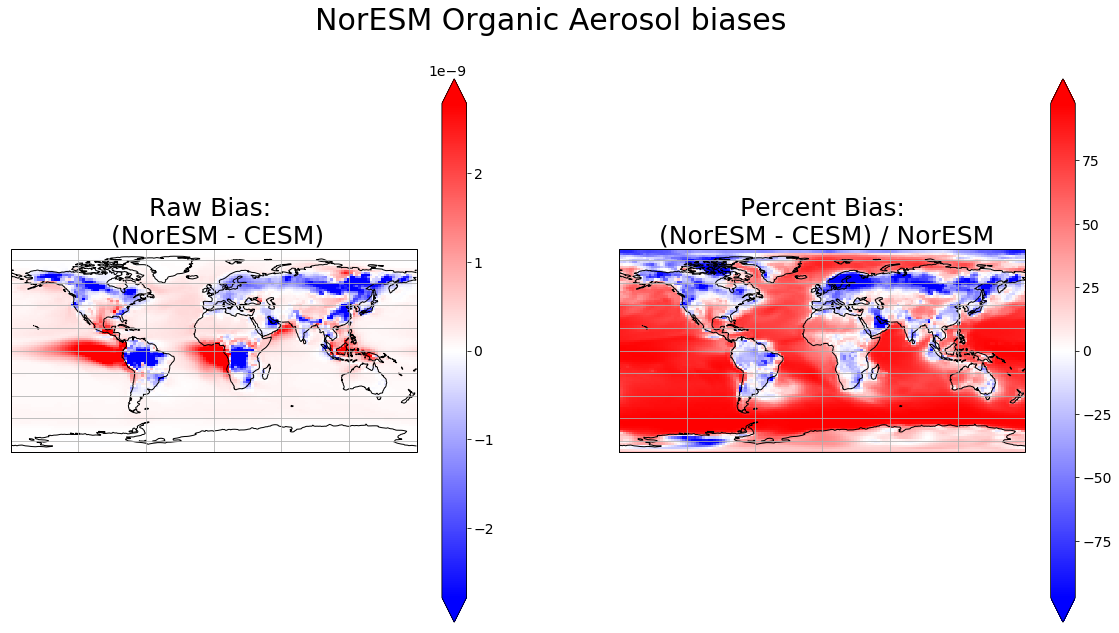

In [18]:
_oa_bias_july = (ds_comp['noresm_mmroa'] - ds_comp['cesm_mmroa'])[6]
_oa_fracbias_july = 100 * _oa_bias_july / (ds_comp['noresm_mmroa'][6])

fig2 = plt.figure(2, figsize=[20,10])

# Plot 1 for Northern Hemisphere subplot argument (nrows, ncols, nplot)
# here 1 row, 2 columns and 1st plot
ax1 = plt.subplot(1, 2, 1, projection=ccrs.PlateCarree())

# Plot 2 for Southern Hemisphere
# 2nd plot 
ax2 = plt.subplot(1, 2, 2, projection=ccrs.PlateCarree())

minval = -1
maxval = 1
titles = ['Raw Bias: \n (NorESM - CESM)','Percent Bias:\n (NorESM - CESM) / NorESM']
#titles = ['Raw Bias: \n (CESM - NorESM)','Fractional Bias:\n  (C$_{ESM}$ - NorESM)}{NorESM}']

for ax,t,n in zip([ax1, ax2], [_oa_bias_july, _oa_fracbias_july], titles):
    map = t.plot(ax=ax, robust = True,
                                           transform=ccrs.PlateCarree(), 
                                           cmap='bwr')
    ax.set_title(n , fontsize=25)
    ax.coastlines()
    ax.gridlines()

    
# Title for both plots
fig2.suptitle('NorESM Organic Aerosol biases', fontsize=30)

<function matplotlib.pyplot.colorbar(mappable=None, cax=None, ax=None, **kw)>

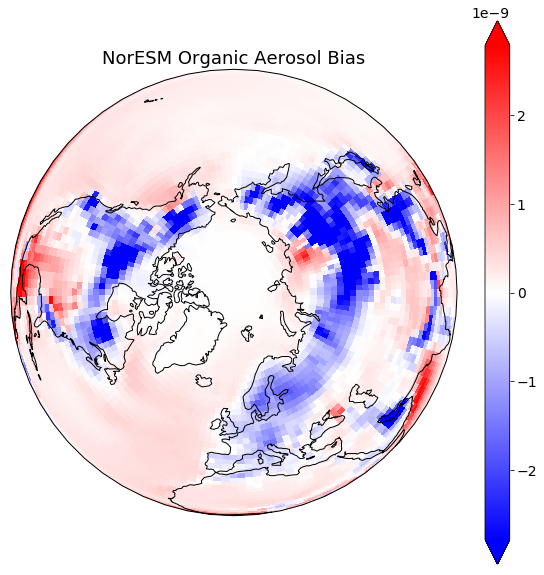

In [19]:
_oa_bias_july = (ds_comp['noresm_mmroa'] - ds_comp['cesm_mmroa'])[6]
fig2 = plt.figure(2, figsize=[10,10])

# We're using cartopy and are plotting in Orthographic projection 
# (see documentation on cartopy)
ax = plt.subplot(1, 1, 1, projection=ccrs.Orthographic(0, 90))
ax.coastlines()

# We need to project our data to the new Orthographic projection and for this we use `transform`.
# we set the original data projection in transform (here PlateCarree)
#noresm_ratio.plot(ax=ax2, transform=ccrs.PlateCarree(), cmap='coolwarm', robust=True)
#ds['aerosol_ratio_bias'].plot(ax=ax, transform=ccrs.PlateCarree(), cmap='coolwarm', robust=True)
_oa_bias_july.plot(ax=ax, transform=ccrs.PlateCarree(), cmap='bwr', robust=True)

# One way to customize your title
plt.title('NorESM Organic Aerosol Bias', fontsize=18)
plt.colorbar

In [20]:
filename = "aero_ratio_bias_polar_2006"
fig2.savefig(base_dir + filename  + '.pdf')
fig2.clf()

<function matplotlib.pyplot.colorbar(mappable=None, cax=None, ax=None, **kw)>

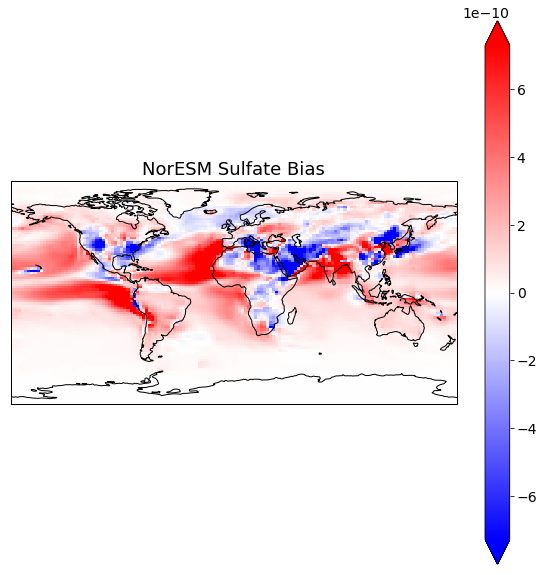

In [23]:
_so4_bias_july = (ds_comp['noresm_mmrso4'] - ds_comp['cesm_mmrso4'])[6]
fig2 = plt.figure(2, figsize=[10,10])

# We're using cartopy and are plotting in Orthographic projection 
# (see documentation on cartopy)
ax = plt.subplot(1, 1, 1, projection=ccrs.PlateCarree())
ax.coastlines()

# We need to project our data to the new Orthographic projection and for this we use `transform`.
# we set the original data projection in transform (here PlateCarree)
#noresm_ratio.plot(ax=ax2, transform=ccrs.PlateCarree(), cmap='coolwarm', robust=True)
#ds['aerosol_ratio_bias'].plot(ax=ax, transform=ccrs.PlateCarree(), cmap='coolwarm', robust=True)
_so4_bias_july.plot(ax=ax, transform=ccrs.PlateCarree(), cmap='bwr', robust=True)

# One way to customize your title
plt.title('NorESM Sulfate Bias', fontsize=18)
plt.colorbar

AttributeError: Unknown property vmin

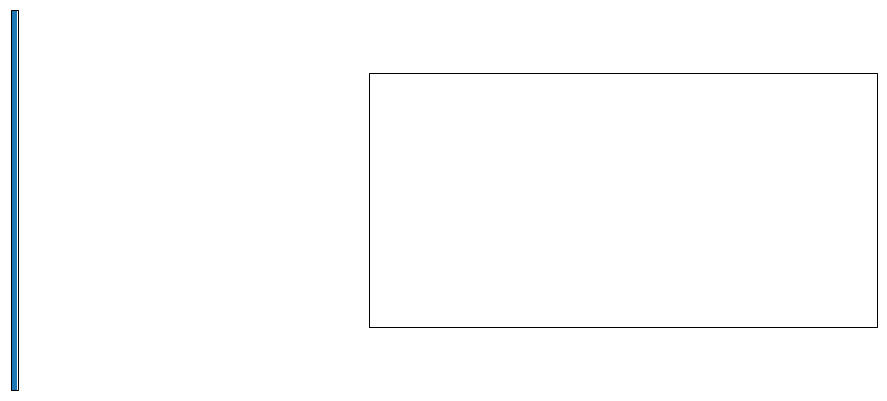

In [21]:
fig3 = plt.figure(2, figsize=[20,7])
# Plot 1 for Northern Hemisphere subplot argument (nrows, ncols, nplot)
# here 1 row, 2 columns and 1st plot
ax1 = plt.subplot(1, 2, 1, projection=ccrs.PlateCarree())

# Plot 2 for Southern Hemisphere
# 2nd plot 
ax2 = plt.subplot(1, 2, 2, projection=ccrs.PlateCarree())

minval = -1
maxval = 1
titles = ['Raw Bias: (CESM - NorESM)','Fractional Bias: (CESM - NorESM) / NorESM']

for ax,t,n in zip([ax1, ax2], ["aerosol_ratio_bias", "fractional_ratio_bias"], titles):
    map = ds[t].plot(ax=ax, vmin=minval, vmax=maxval,
                                           transform=ccrs.PlateCarree(), 
                                           cmap='coolwarm', 
                                           add_colorbar=False)
    ax.set_title(n , fontsize=22)
    ax.coastlines()
    ax.gridlines()

cbar_ax = fig3.add_axes([0.325, 0.15, 0.4, 0.04])    
cbar = fig3.colorbar(map, cax=cbar_ax, orientation='horizontal')

cbar.ax.tick_params(labelsize=20)
#cbar.ax.set_xlabel('Organic Aerosol Fraction', fontsize=16)

In [ ]:
filename = "aero_ratio_bias_global_2006"
fig3.savefig(base_dir + filename  + '.pdf')
fig3.clf()

# Delete Zone

$\frac{'Organic Aerosol'}{'Organic Aerosol + black carbon + Sulfate}$

## $\frac{1}{2}$

$\frac{mmr_{oa}+mmr_{bc}+mmr_{so4}}{mmr_{oa}}$

$\frac{oa}{oa + bc + so4}$

In [ ]:
ds

In [ ]:
ds['noresm_ratio']

In [ ]:
{'Zeppelin': [78.907206, 11.885593]}